# 2D ERT modelling and inversion with ResIPy
This tutorial performs ERT forward modelling with `ResIPy` and comes directly from [here](https://hkex.gitlab.io/resipy/gallery/nb_06forward.html)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from resipy import Project

API path =  /home/alberto/anaconda3/envs/electro/lib/python3.11/site-packages/resipy
ResIPy version =  3.6.1
cR2.exe found and up to date.
R3t.exe found and up to date.
cR3t.exe found and up to date.


## 1. Initialize R2 and design the survey
First we need to define electrodes and spacing.


In [2]:
k = Project(typ='R2') # create R2 object

n_elecs = 48
dx = 1

elec = np.zeros((n_elecs,3))
elec[:,0] = np.arange(0, n_elecs*dx, dx) # 1 m spacing and 48 electrodes
k.setElec(elec)
k.elec.head()

Working directory is: /home/alberto/anaconda3/envs/electro/lib/python3.11/site-packages/resipy
clearing dirname


,label,x,y,z,remote,buried
0,1,0.0,0.0,0.0,False,False
1,2,1.0,0.0,0.0,False,False
2,3,2.0,0.0,0.0,False,False
3,4,3.0,0.0,0.0,False,False
4,5,4.0,0.0,0.0,False,False


Now let's create a mesh.

Creating triangular mesh...done (4686 elements)


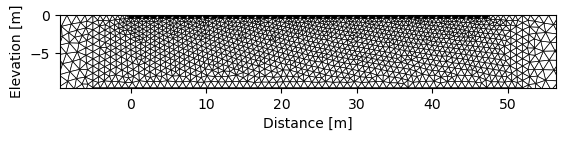

In [3]:
k.createMesh(typ='trian', cl=.5, fmd=n_elecs*dx/5, res0=200) # mesh based on electrodes position, with 200 ohm.m as background resistivity
k.showMesh()

## 2. Create the model
Based on this mesh, we can defined regions and assign them resistivities. There is an interactive way to do it when working outside of the jupyter notebook in interactive mode or GUI.  
Here we will see the pure API based way to do it using `R2.addRegion()`, first specifying the path of the region and then its resistivity value in Ohm.m

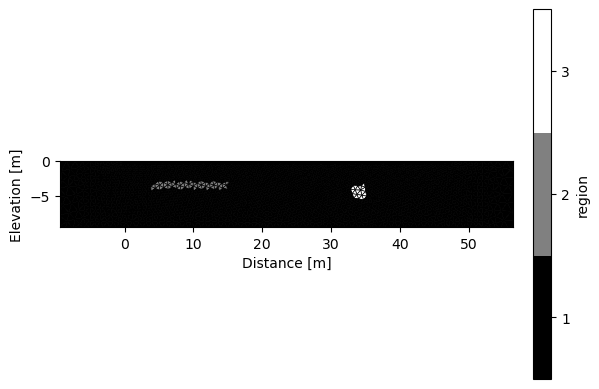

In [4]:
k.addRegion(np.array([[4,-3],[4,-4],[15,-4],[15,-3],[4,-3]]), 30, iplot=False) # conductive clay lense
k.addRegion(np.array([[33,-3.5],[33,-5.5],[35,-5.5],[35,-3.5],[33,-3.5]]), 1500, iplot=True) # resistive boulder

We then need to define the sequence that we will use. We can easily create a dipole-dipole sequence using `R2.createSequence()` or import one using `R2.importSequence()`.

In [5]:
k.createSequence([('dpdp1', 2, 40)]) # create a dipole-dipole of diple spacing of 1 (=skip 0) with 10 levels
print(k.sequence) # the sequence is stored inside the R2 object

462 quadrupoles generated.
[[ 1  3  5  7]
 [ 2  4  6  8]
 [ 3  5  7  9]
 ...
 [ 4  6 46 48]
 [ 1  3 45 47]
 [ 2  4 46 48]]


Then comes the forward modelling part itself. The forward modelling will run R2, cR2, ... in forward mode inside a `fwd` directory inside the working directory.  
The resulting apparent resistivity are then embeded inside a `Survey` object and directly available for inversion for instance.

Writing .in file and mesh.dat... done
Writing protocol.dat... done
Running forward model... 

0120:fixme:ntdll:EtwEventSetInformation (deadbeef, 2, 0000000145007BE0, 43) stub




 >> R  2    R e s i s t i v i t y   I n v e r s i o n   v4.10 <<

 >> D a t e : 02 - 09 - 2025
 >> My beautiful survey                                                             
 >> F o r w a r d   S o l u t i o n   S e l e c t e d <<
 >> Determining storage needed for finite element conductance matrix
 >> Generating index array for finite element conductance matrix
 >> Reading start resistivity from resistivity.dat               

 Measurements read:   462     Measurements rejected:     0

 >> Total Memory required is:          0.001 Gb


All ok
0120:fixme:ver:GetCurrentPackageId (00007FFFFE1FEBA0 0000000000000000): stub
/home/alberto/anaconda3/envs/electro/lib/python3.11/site-packages/numpy/lib/function_base.py:2458: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res = asanyarray(outputs, dtype=otypes[0])


filterData: 0 / 462 quadrupoles removed.
0/462 reciprocal measurements found.
Forward modelling done.

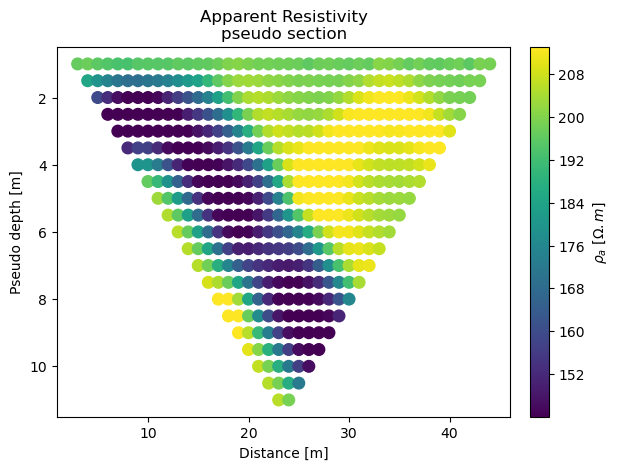

In [6]:
k.forward(noise=0.05, iplot=True) # forward modelling with 5 % noise added to the output

We can see that the pseudo-section already show clearly the import on the region we defined.

## 3. Inversion and output
We can now invert these apparent resistivities. Inverting the forward models allows the user to see if the parameters of the surveys (the **sequence** and **electrode spacing**) were optimium to resolve the target. If needed, he can change them and redo the whole process.

In [7]:
k.param['data_type'] = 1 # using log of resistitivy
k.param['a_wgt'] = 0.01 # absolute error (mV)
k.param['b_wgt'] = 0.05 # relative error (%)
k.invert()

Writing .in file and protocol.dat... All non fixed parameters reset to 100 Ohm.m and 0 mrad, as the survey to be inverted is from a forward model.
done

--------------------- MAIN INVERSION ------------------


0130:fixme:ntdll:EtwEventSetInformation (deadbeef, 2, 0000000145007BE0, 43) stub




 >> R  2    R e s i s t i v i t y   I n v e r s i o n   v4.10 <<

 >> D a t e : 02 - 09 - 2025
 >> My beautiful survey                                                             
 >> I n v e r s e   S o l u t i o n   S e l e c t e d <<
 >> Determining storage needed for finite element conductance matrix
 >> Generating index array for finite element conductance matrix
 >> Reading start resistivity from res0.dat                      
 >> R e g u l a r i s e d   T y p e <<
 >>   L i n e a r    F i l t e r    <<
 >> L o g - D a t a   I n v e r s i o n <<
 >> N o r m a l   R e g u l a r i s a t i o n <<
 >> D a t a   w e i g h t s   w i l l   b e  m o d i f i e d <<


 Processing dataset   1


 Measurements read:   462     Measurements rejected:     0
   Geometric mean of apparent resistivities:  0.18231E+03

 >> Total Memory required is:          0.019 Gb

   Iteration   1
     Initial RMS Misfit:         7.72       Number of data ignored:     0
     Alpha:          53.425   RMS Misfit:

All ok
0130:fixme:ver:GetCurrentPackageId (00007FFFFE1FEBA0 0000000000000000): stub


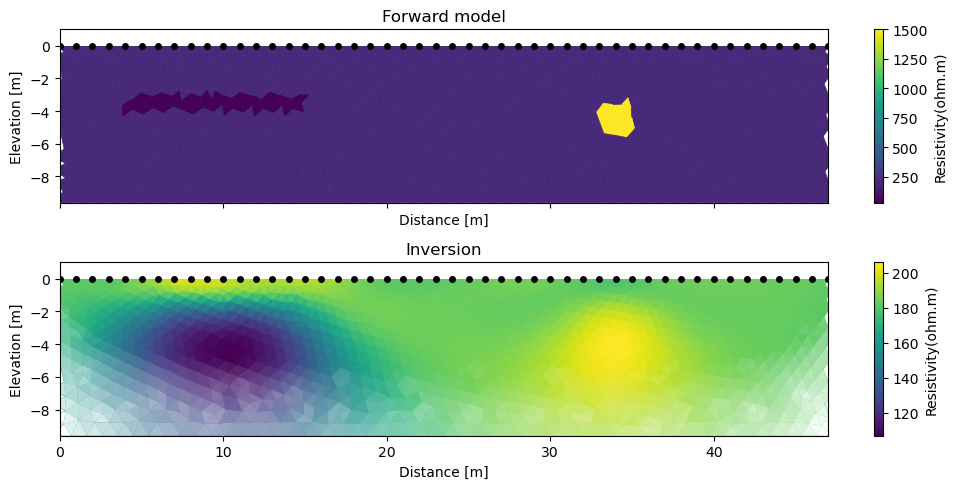

In [8]:
# show
fig, axs = plt.subplots(2,1, sharex=True, figsize=(12,5))
k.showResults(index=0, ax=axs[0], sens=False, attr='Resistivity(ohm.m)')
axs[0].set_title('Forward model')
k.showResults(index=1, ax=axs[1], attr='Resistivity(ohm.m)', #vmin=130, vmax=210
             )
axs[1].set_title('Inversion')

for ax in axs:
    ax.set_xlim(0,  n_elecs*dx-dx)
    ax.set_ylim(-n_elecs*dx/5, 1)
    
fig.tight_layout()
#fig.savefig(outputdir + fname + '-resipy.png', dpi=200)

Inversion is a smoothing process. The anomalies created in direct modeling are not recovered perfectly in either form or value, and this is normal.  
The effectiveness of the survey can be improved by performing a **target-specific study** of electrode number and position, and acquisition sequence. Data processing and inversion settings also make an important contribution.  
The experienced user must then proceed with a careful interpretation, taking into account all other possible accompanying information.